In [ ]:
!pip install opendatasets
!pip install split-folders
# !pip install tensorflow

In [ ]:
import opendatasets as od
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report

### write any name or any passoward >>name: hfdd, password 343433

In [ ]:
od.download("https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rtrtr
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset


100%|██████████| 380M/380M [00:05<00:00, 67.3MB/s]


In [ ]:
import splitfolders

splitfolders.ratio(
    "/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset",
    output="/content/alzheimer_split",
    seed=42,
    ratio=(0.8, 0.2)
)


Copying files: 33984 files [00:08, 4243.74 files/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/alzheimer_split/train",
    image_size=(224,224),
    batch_size=32
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/alzheimer_split/val",
    image_size=(224,224),
    batch_size=32
)


Found 27187 files belonging to 4 classes.
Found 6797 files belonging to 4 classes.


In [ ]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     "/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset",
#  validation_split = 0.2,subset = "training",seed=42,image_size=(224,224),batch_size=32)


Found 33984 files belonging to 4 classes.
Using 27188 files for training.


In [ ]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#     "/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset",
#  validation_split = 0.2,subset = "validation",seed=42,image_size=(224,224),batch_size=32)


Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


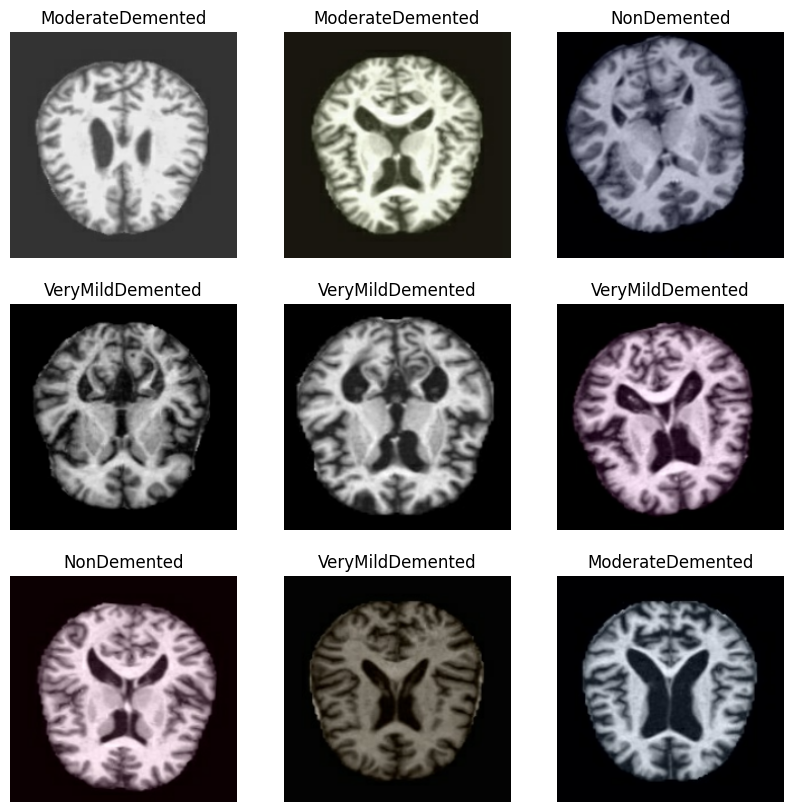

In [ ]:
for images,lagels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[lagels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
autotune = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=autotune)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=autotune)
print(class_names)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
earlyS = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)

model = models.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlyS]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
142/850 ━━━━━━━━━━━━━━━━━━━━ 59:26 5s/step - accuracy: 0.3024 - loss: 1.3610

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation accuracy = {acc*100:.2f}%")




In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# عرض منحنى الـ Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/augmented-alzheimer-mri-dataset/OriginalDataset",
    image_size=(224,224),
    batch_size=32
).map(lambda x,y: (normalization_layer(x), y))

test_loss, test_acc = model.evaluate(test_ds)
print(f"🎯 Test Accuracy on Original Data: {test_acc*100:.2f}%")


In [ ]:
model.save("/content/alzheimer_model.h5")

In [ ]:

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = False

# ✅ بناء الموديل
model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

earlyS = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlyS]
)


In [ ]:

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlyS]
)


In [ ]:
def combine_history(h1, h2):
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]
    return history
full_history = combine_history(history1, history2)


plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(full_history['accuracy'], label='Train Acc')
plt.plot(full_history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

to install requirement run this code

In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download("requirements.txt")


In [ ]:
%%writefile requirements.txt
streamlit
tensorflow
numpy
pillow
from google.colab import files
files.download("requirements.txt")
